In [ ]:
import sys
from pathlib import Path


sys.path.append(str(Path().resolve().parent / "src")) # Add src to path for imports


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from config import PROCESSED_PATH 

In [ ]:
df = pd.read_csv(PROCESSED_PATH) # Load the processed dataset
df.info()
df['Age'].describe() # Quick stats on Age column
df['satisfaction'].value_counts(dropna=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             25976 non-null  object 
 1   Customer Type                      25976 non-null  object 
 2   Age                                25976 non-null  int64  
 3   Type of Travel                     25976 non-null  object 
 4   Class                              25976 non-null  object 
 5   Flight Distance                    25976 non-null  int64  
 6   Inflight wifi service              25976 non-null  int64  
 7   Departure/Arrival time convenient  25976 non-null  int64  
 8   Ease of Online booking             25976 non-null  int64  
 9   Gate location                      25976 non-null  int64  
 10  Food and drink                     25976 non-null  int64  
 11  Online boarding                    25976 non-null  int

satisfaction
neutral or dissatisfied    14573
satisfied                  11403
Name: count, dtype: int64

In [12]:
bins = [0, 17, 25, 35, 45, 60, df['Age'].max()] #age intervals 
labels = ['0-17 : Child', '18-25 : Youth', '26-35 : Young Adult', '36-45 : Adult', '46-60 : Mature', '60+ : Senior'] #age group labels

df["AgeGroup"] = pd.cut(
    df['Age'],
    bins=bins, #intervals we defined
    labels=labels, #group names
    include_lowest=True, #include the lowest value in the first bin
    right=True #include the right edge of the interval
)

df[["Age", "AgeGroup"]].head(10)

,Age,AgeGroup
0,52,46-60 : Mature
1,36,36-45 : Adult
2,20,18-25 : Youth
3,44,36-45 : Adult
4,49,46-60 : Mature
5,16,0-17 : Child
6,77,60+ : Senior
7,43,36-45 : Adult
8,47,46-60 : Mature
9,46,46-60 : Mature


In [13]:
# Map satisfaction values into two clean categories
satisfaction_map = {
    "satisfied": "Satisfied",
    "neutral or dissatisfied": "Unsatisfied"
}

df["SatisfactionBinary"] = df["satisfaction"].map(satisfaction_map) # Create a new column with mapped values

# Quick check of the new column
df["SatisfactionBinary"].value_counts()


SatisfactionBinary
Unsatisfied    14573
Satisfied      11403
Name: count, dtype: int64

In [ ]:
# Crosstab: rows = AgeGroup, columns = SatisfactionBinary
age_satisfaction_pct = pd.crosstab(
    df["AgeGroup"], 
    df["SatisfactionBinary"], 
    normalize="index"
) * 100

# Reorder rows to follow our age group labels
age_satisfaction_pct = age_satisfaction_pct.reindex(labels)

age_satisfaction_pct # Display the crosstab percentages


SatisfactionBinary,Satisfied,Unsatisfied
AgeGroup,,
0-17 : Child,18.110647,81.889353
18-25 : Youth,35.894621,64.105379
26-35 : Young Adult,38.018628,61.981372
36-45 : Adult,52.430384,47.569616
46-60 : Mature,57.508284,42.491716
60+ : Senior,20.741097,79.258903


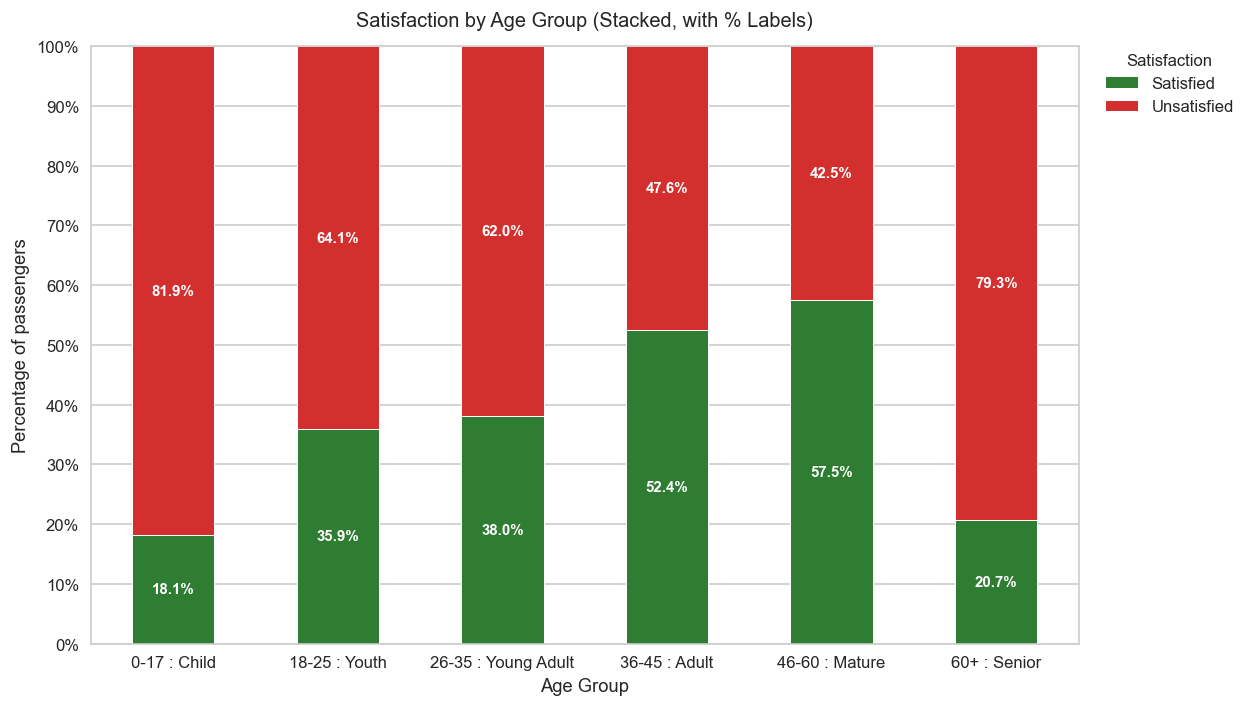

In [32]:
# --- Polished stacked chart (pandas) with readable legend and labels ---

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, PercentFormatter

# 1) Recompute percentages safely (0..100) and also keep sample sizes per group
counts = pd.crosstab(df["AgeGroup"], df["SatisfactionBinary"]).reindex(labels)
pct = counts.div(counts.sum(axis=1), axis=0) * 100
n_per_group = counts.sum(axis=1)

# 2) Use a clean style (white grid) – still pure matplotlib/pandas (no seaborn API)
plt.style.use("seaborn-v0_8-whitegrid")

fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

# 3) Draw stacked bars with consistent colors
colors = {"Satisfied": "#2E7D32", "Unsatisfied": "#D32F2F"}  # darker tones for contrast
pct[["Satisfied", "Unsatisfied"]].plot(
    kind="bar",
    stacked=True,
    color=[colors["Satisfied"], colors["Unsatisfied"]],
    edgecolor="white",
    linewidth=0.6,
    ax=ax
)

# 4) Axis cosmetics: 0..100, nicer ticks and percent formatter
ax.set_ylim(0, 100)
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))
ax.set_ylabel("Percentage of passengers")
ax.set_xlabel("Age Group")
ax.set_title("Satisfaction by Age Group (Stacked, with % Labels)", pad=12)

# 5) Put the legend OUTSIDE (right side) so bars are never hidden
ax.legend(
    title="Satisfaction",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0.0,
    frameon=False
)

# 6) Write correct % labels INSIDE each stacked segment
for i, (grp, row) in enumerate(pct.iterrows()):
    s = float(row["Satisfied"])
    u = float(row["Unsatisfied"])
    # center of green segment
    ax.text(i, s / 2, f"{s:.1f}%", ha="center", va="center",
            color="white", fontsize=9, fontweight="bold")
    # center of red segment (stacked above green)
    ax.text(i, s + (u / 2), f"{u:.1f}%", ha="center", va="center",
            color="white", fontsize=9, fontweight="bold")

# 7) Small visual touches
ax.tick_params(axis="x", rotation=0)
ax.set_axisbelow(True)  # draw grid behind bars

# 8) Tight layout WITH room for the outside legend
plt.tight_layout(rect=[0, 0, 0.88, 1])  # leave space on the right
plt.show()


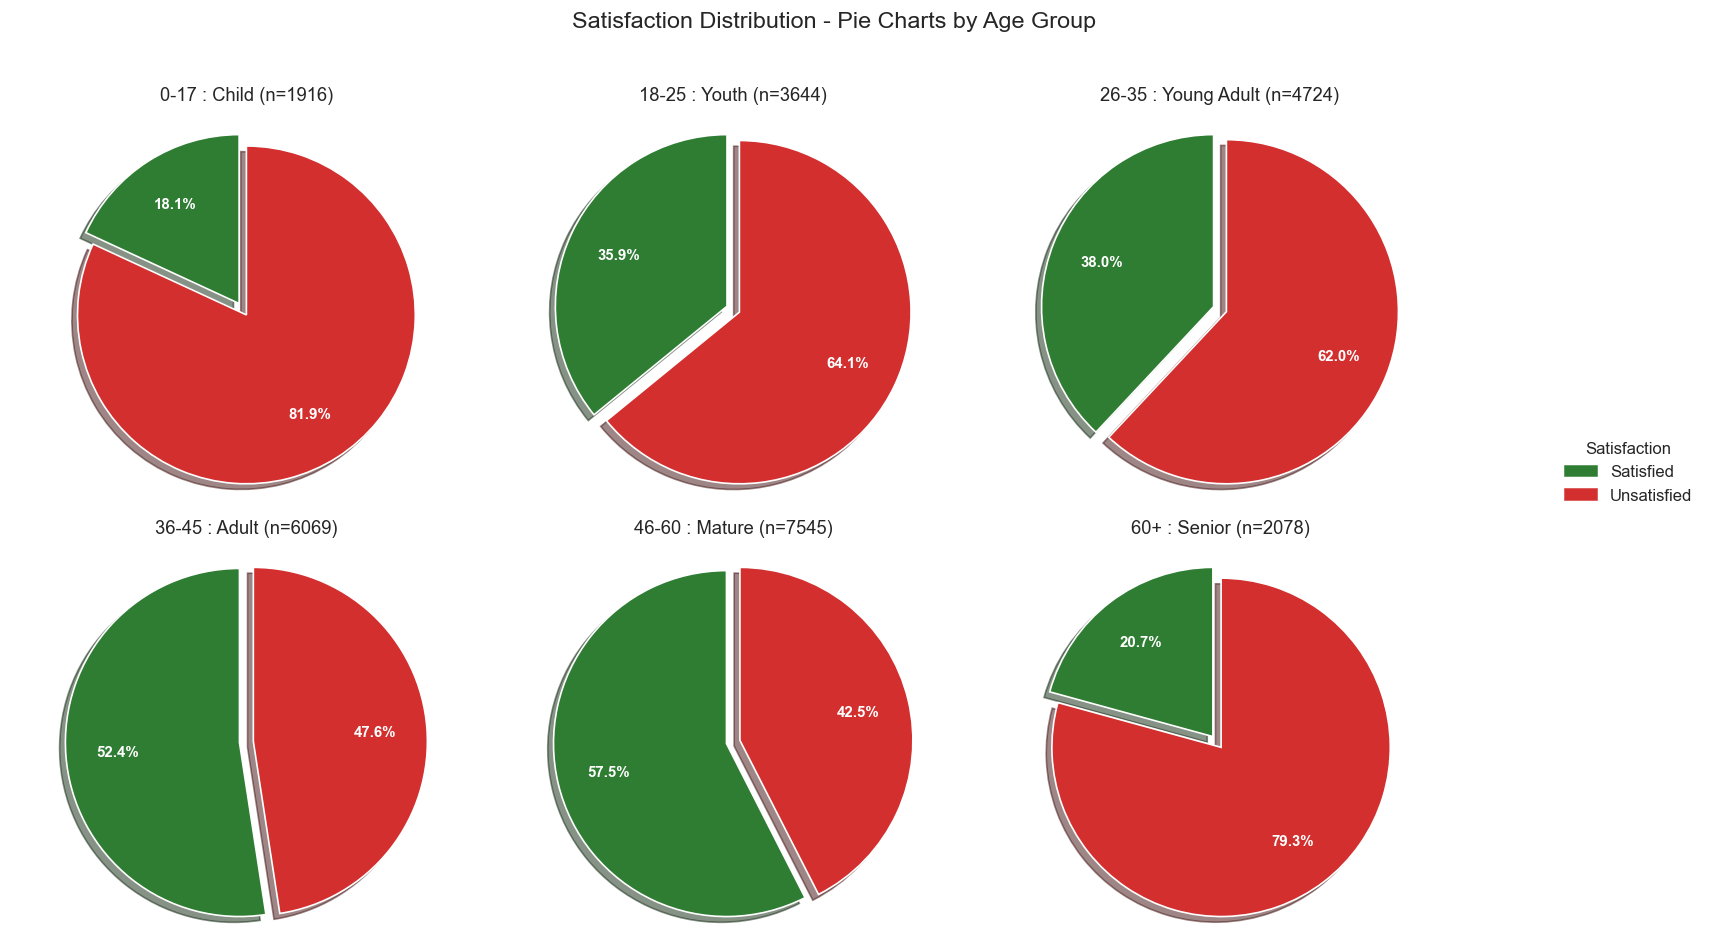

In [34]:
# --- Pie charts by Age Group (single figure with 6 subplots, fixed unpacking) ---

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 1) Recompute counts and percentages to be safe (0..100)
counts = pd.crosstab(df["AgeGroup"], df["SatisfactionBinary"]).reindex(labels)
pct = counts.div(counts.sum(axis=1), axis=0) * 100
n_per_group = counts.sum(axis=1)  # sample size per age group

# 2) Consistent colors matching the stacked chart
colors = {"Satisfied": "#2E7D32", "Unsatisfied": "#D32F2F"}

# 3) Use a clean style without grid lines for pies
plt.style.use("seaborn-v0_8-white")

# 4) Create a 2x3 grid to host 6 pie charts
fig, axes = plt.subplots(2, 3, figsize=(14, 8), dpi=120)
axes = axes.flatten()

for i, group in enumerate(pct.index):
    # Values in order: Satisfied then Unsatisfied (must match the colors)
    values = pct.loc[group, ["Satisfied", "Unsatisfied"]].to_numpy()

    # Slight "explode" and shadow for a gentle 3D-like effect
    explode = (0.04, 0.04)

    # 5) pie() returns THREE things when autopct is used: wedges, texts, autotexts
    wedges, texts, autotexts = axes[i].pie(
        values,
        labels=None,  # keep pies clean; legend on the right will explain colors
        autopct="%.1f%%",  # show percentages on slices
        pctdistance=0.7,   # move percentage labels slightly inward
        startangle=90,     # start from top
        colors=[colors["Satisfied"], colors["Unsatisfied"]],
        explode=explode,
        shadow=True,
        wedgeprops={"linewidth": 1, "edgecolor": "white"}
    )

    # Make percentage labels readable on colored wedges
    for t in autotexts:
        t.set_color("white")
        t.set_fontweight("bold")
        t.set_fontsize(9)

    # Ensure perfect circle and remove grids around each subplot
    axes[i].axis("equal")
    axes[i].grid(False)

    # Title includes the group name and sample size
    axes[i].set_title(f"{group} (n={int(n_per_group.loc[group])})", fontsize=11, pad=10)

# 6) Single shared legend on the right so it never overlaps a pie
legend_handles = [
    Patch(color=colors["Satisfied"], label="Satisfied"),
    Patch(color=colors["Unsatisfied"], label="Unsatisfied"),
]
fig.legend(
    handles=legend_handles,
    title="Satisfaction",
    loc="center right",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
)

# 7) Global title + tidy layout (leave space for the outside legend)
fig.suptitle("Satisfaction Distribution - Pie Charts by Age Group", fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0, 0.88, 0.96])
plt.show()


In [36]:
# Save the stacked chart
from pathlib import Path
Path("../reports/figures").mkdir(parents=True, exist_ok=True)
fig_stacked = ax.get_figure()
fig_stacked.savefig("../reports/figures/age_satisfaction_stacked_pandas_clean.png",
                    dpi=200, bbox_inches="tight")


In [37]:
# Save the pie charts figure
from pathlib import Path
Path("../reports/figures").mkdir(parents=True, exist_ok=True)
fig.savefig("../reports/figures/age_satisfaction_pies_clean.png",
            dpi=200, bbox_inches="tight")


In [38]:
from pathlib import Path
Path("../reports/tables").mkdir(parents=True, exist_ok=True)
pct.to_csv("../reports/tables/age_satisfaction_percent.csv")
